<a href="https://colab.research.google.com/github/ankishore/predict_alcohol_sales/blob/main/lstm_alcohal_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset

In [2]:
# Use col 0 for row label and convert dates to timestamp object.
df = pd.read_csv('https://raw.githubusercontent.com/ankishore/predict_alcohol_sales/main/Alcohol_Sales.csv', index_col=0, parse_dates=True)

# Plot time series dataset

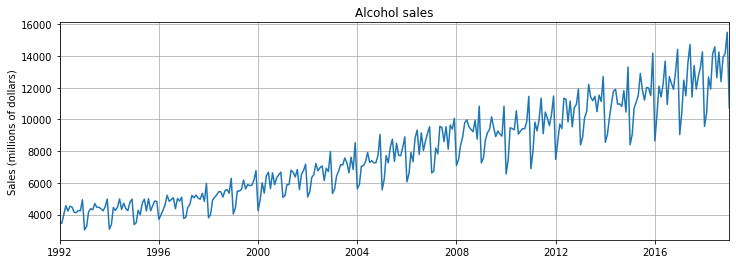

In [3]:
plt.figure(figsize=(12, 4)) # Create a new figure of width:12, height:4 inches
plt.title('Alcohol sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

# Prepare training and test dataset

In [4]:
y = df['S4248SM144NCEN'].values.astype(float) # return numpy

test_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

# Normalize dataset
Only training dataset is notmalized to avoid leaking test dataset info to training.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

# Prepare data for LSTM
Create list of sequence/label tuples from training set

In [6]:
train_norm = torch.FloatTensor(train_norm).view(-1)

window_size = 12

def input_data(seq, ws):
  out = []
  L =len(seq)

  for i in range(L - ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    out.append((window, label))
  
  return out

# list of tuples (seq of 12 entries, label i.e next in sequence)
train_data = input_data(train_norm, window_size)

# Define the model

In [8]:
class LSTMnetwork(nn.Module):
  """
  input_size: Number of features in each entry of the sequence
  hidden_size: Number of hidden/cell states for each entry of the sequence
  output_size: Number of outputs from output layer
  """
  def __init__(self, input_size=1, hidden_size=100, output_size=1):
    super().__init__()
    self.hidden_size = hidden_size

    # Add LSTM layer
    self.lstm = nn.LSTM(input_size, hidden_size)

    # Add fully connected layer
    self.linear = nn.Linear(hidden_size, output_size)

    # Intialize hidden states i.e. h_0 and cell states i.e. c_0
    self.hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
  
  def forward(self, seq):
    lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
    pred = self.linear(lstm_out.view(len(seq), -1))

    return pred[-1] # We need only last value

# Instantiate model, define loss and optimization functions

In [9]:
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model

In [12]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):

  # extract sequence and label
  for seq, y_train in train_data:

    # reset
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1, 1, model.hidden_size), torch.zeros(1, 1, model.hidden_size))

    y_pred = model(seq)

    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
  
  print(f'Epoch: {epoch:2} Loss: {loss.item():10.8f}')

print(f'Duration: {time.time() - start_time:.0f} seconds')

Epoch:  0 Loss: 0.29550740
Epoch:  1 Loss: 0.31543383
Epoch:  2 Loss: 0.34217247
Epoch:  3 Loss: 0.32660645
Epoch:  4 Loss: 0.32783213
Epoch:  5 Loss: 0.31873789
Epoch:  6 Loss: 0.32252783
Epoch:  7 Loss: 0.31322473
Epoch:  8 Loss: 0.30704364
Epoch:  9 Loss: 0.31108579
Epoch: 10 Loss: 0.28937638
Epoch: 11 Loss: 0.30109856
Epoch: 12 Loss: 0.27795938
Epoch: 13 Loss: 0.29239655
Epoch: 14 Loss: 0.25680763
Epoch: 15 Loss: 0.27149326
Epoch: 16 Loss: 0.16470684
Epoch: 17 Loss: 0.08973063
Epoch: 18 Loss: 0.18664168
Epoch: 19 Loss: 0.27525622
Epoch: 20 Loss: 0.17801334
Epoch: 21 Loss: 0.00652012
Epoch: 22 Loss: 0.08783571
Epoch: 23 Loss: 0.32992956
Epoch: 24 Loss: 0.03327563
Epoch: 25 Loss: 0.05387892
Epoch: 26 Loss: 0.02992455
Epoch: 27 Loss: 0.02297021
Epoch: 28 Loss: 0.01182169
Epoch: 29 Loss: 0.00875726
Epoch: 30 Loss: 0.00362136
Epoch: 31 Loss: 0.00667203
Epoch: 32 Loss: 0.00516182
Epoch: 33 Loss: 0.00408513
Epoch: 34 Loss: 0.00352528
Epoch: 35 Loss: 0.00267228
Epoch: 36 Loss: 0.00269342
E

# Predict and compare with test set

In [14]:
future = 12

# Add last winfow of training vaues to list of predictions
preds = train_norm[-window_size:].tolist()

model.eval()

# predict 12 points in future
for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])

  with torch.no_grad():
    model.hidden = (torch.zeros(1, 1, model.hidden_size), torch.zeros(1, 1, model.hidden_size))
    preds.append(model(seq).item())

# print predicted values
preds[window_size:]

[0.3513810634613037,
 0.6990900039672852,
 0.3708747625350952,
 0.821702241897583,
 0.9447658061981201,
 0.4492798447608948,
 0.7758744955062866,
 0.5045931339263916,
 0.6316124200820923,
 0.7322007417678833,
 0.9623121023178101,
 0.11149564385414124]

# Invert normalization on predicted values

In [16]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10935.90353072],
       [12969.82697821],
       [11049.93192345],
       [13687.04726398],
       [14406.90758336],
       [11508.56245193],
       [13418.97786146],
       [11832.1175369 ],
       [12575.11685127],
       [13163.50823897],
       [14509.54464251],
       [ 9532.69376872]])

# Print real values

In [17]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64